In [ ]:
# default_exp core

# SGNN

> Implementation of Self-Governing Neural Networks for speech act classification

## Implementation of the [SGNN paper](https://www.aclweb.org/anthology/D19-1402.pdf) for speech act classification.
This repository is inspired by Guillaume Chevalier's [implementation](https://github.com/guillaume-chevalier/SGNN-Self-Governing-Neural-Networks-Projection-Layer), as well as his [discussion](https://github.com/guillaume-chevalier/SGNN-Self-Governing-Neural-Networks-Projection-Layer/issues/1) with [Sava Kalbachou](https://github.com/thinline).
This version implements some things differently from Guillaume's code, in an attempt to resemble the paper more, and extends beyond the projection layer all the way to a fully trainable network.

The network is trained to classify the [SwDA corpus](https://web.stanford.edu/~jurafsky/ws97/) utterances according to their speech act. The corpus was was pre-processed using Cristopher Pott's [project](https://github.com/cgpotts/swda/) related to it. To follow Lee & Dernoncourt SwDA data split, as in the SGNN paper, we added [adequate functionality](https://github.com/glicerico/swda/blob/data_split/create_sets.py) in our [branch](https://github.com/glicerico/swda/tree/data_split) of that repo. The pre-processed data is included in the [`data`](data) folder for repeateability.

In [ ]:
#hide
from nbdev.showdoc import *

## Required modules

In [ ]:
#export
import functools
import random as rand
import re

from livelossplot import PlotLossesKerasTF
from nearpy.hashes import RandomBinaryProjections
from nltk.util import skipgrams
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow.keras as keras

/home/andres/src/miniconda3/envs/speechActs/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/andres/src/miniconda3/envs/speechActs/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/andres/src/miniconda3/envs/speechActs/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/andres/src/mi

## Import data from file

In [ ]:
#export
def import_data(filepath):
    """
    Imports data from file and removes empty entries
    :param filepath:  Path to file with SwDa utterances in format "ActTag,Text"
    :return:          pandas dataframe with the data
    """
    data = pd.read_csv(filepath)
    data = data.dropna(axis=0)  # Drop rows with NA values
    
    return data
    

## Preprocess data, and divide it in train, validation and test sets

In [ ]:
#export    
def preprocess_data(data, lowercase=False, clean=False, remove_continuations=True):
    """
    Preprocess the data according to parameters. 
    Divides the data into training, validation and test sets.
    
    :param data:  Pandas dataframe imported by `import_data`
    Optional:
    :param lowercase:  Convert all text to lowercase
    :param clean:  Remove punctuation marks and non-verbal utterances
    :param remove_continuations:  Remove utterances with act tag "+"
    
    :return:  Pandas series with training, validation and test tags and utterances
    """
    if lowercase:
        data['Text'] = data['Text'].str.lower()
    if clean:
        # Remove punctuation
        data['Text'] = [re.sub('[(|)|#|.]', '', line) for line in data['Text']]
        # Remove dashes and words in angle brackets (e.g. "<Laughter>")
        data['Text'] = [re.sub('\W-+\W|<\w+>', ' ', line) for line in data['Text']]
    if remove_continuations:
        data = data[~(data.DamslActTag == '+')]
    
    # Remove extra spaces
    data['Text'] = [re.sub('\s+', ' ', line) for line in data['Text']]
    data = data[~(data.Text == ' ')]  # Remove data rows that end up empty after cleaning
                            
    X, y = data.Text, data.DamslActTag
                            
    return X, y


## Transform RandomBinaryProjections to transformer

In [ ]:
#export
class Transformer_RBP(BaseEstimator, RandomBinaryProjections):
    """
    Class that modifies RandomBinaryProjections to use as an sklearn transformer
    """
    rand_seed = None  # Declare it as class variable
    def __init__(self, hash_name='hasher', projection_count=1, rand_seed=None):
        RandomBinaryProjections.__init__(self, hash_name, projection_count, rand_seed=rand_seed)
        
    def fit(self, X, y):
        self.rand = np.random.RandomState(self.rand_seed)  # rand seed after param setting
        self.reset(X.shape[1])
        
    def transform(self, X):
        return self.hash_vector(X)

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
    
    def hash_vector(self, v, querying=False):
        """
        Hashes the vector and returns the binary bucket key as string.
        """
        if sp.issparse(v):
            # If vector is sparse, make sure we have the CSR representation
            # of the projection matrix
            if self.normals_csr is None:
                self.normals_csr = sp.csr_matrix(self.normals)
            # Make sure that we are using CSR format for multiplication
            if not sp.isspmatrix_csr(v):
                v = sp.csr_matrix(v)
            # Project vector onto all hyperplane normals
            # projection = self.normals_csr.dot(v)
            projection = v.dot(sp.csr_matrix.transpose(self.normals_csr))
        else:
            # Project vector onto all hyperplane normals
            projection = np.dot(v, np.matrix.transpose(self.normals))
        # Return binary key
        return projection > 0
    

## Create input layer projections
This is the main contribution of the SGNN paper, and the implementation is inspired by Guillaume Chevalier's [implementation](https://github.com/guillaume-chevalier/SGNN-Self-Governing-Neural-Networks-Projection-Layer), as well as his [discussion](https://github.com/guillaume-chevalier/SGNN-Self-Governing-Neural-Networks-Projection-Layer/issues/1) with [Sava Kalbachou](https://github.com/thinline).

In [ ]:
#export
def build_input_layer(T=80, d=14):
    """
    Transformer to build the input layer, in SGNN style.
    Uses nltk skipgrams, and several Transformer_RBP layers as elements of the SGNN pipeline.
    """
    # T=80 projections for each of dimension d=14: 80 * 14 = 1120-dimensionnal word projections

    # Wrap skipgrams to use with CountVectorizer
    skipper = functools.partial(skipgrams, n=3, k=2) # 2-skip-3-grams
    # CountVectorizer params
    char_term_frequency_params = {
        'char_term_frequency__analyzer': skipper,
        'char_term_frequency__min_df': 3,
        'char_term_frequency__max_df': 0.9,
        'char_term_frequency__max_features': int(1e7),
    }

    # Transformer_RBP params
    rand_seeds = [rand.randint(0, T*100) for i in range(T)] # Need a different repeatable seed for each hasher
    hashing_feature_union_params = {
        **{'union__random_binary_projection_hasher_{}__projection_count'.format(t): d
           for t in range(T)
        },
        **{'union__random_binary_projection_hasher_{}__hash_name'.format(t): 'hasher' + str(t)
           for t in range(T)
        },
        **{'union__random_binary_projection_hasher_{}__rand_seed'.format(t): rand_seeds[t]  # only AFTER hashing.
           for t in range(T)
        }
    }

    # Pipeline to create input layer
    preprocessor = Pipeline([
        ("char_term_frequency", CountVectorizer()),
        ('union', FeatureUnion([
            ('random_binary_projection_hasher_{}'.format(t), Transformer_RBP())
            for t in range(T)
        ]))
    ])
    
    params = dict()
    params.update(char_term_frequency_params)
    params.update(hashing_feature_union_params)
    preprocessor.set_params(**params)
    return preprocessor


## Create keras model
Following the SGNN paper's architecture

In [ ]:
#export
def build_keras_model(train_labels):
    """
    Build keras model, with two hidden layers as the SGNN paper.
    """
    model = keras.Sequential()
#     model.add(keras.layers.Dropout(0.25, input_shape=(1120,)))
#     model.add(keras.layers.Dense(256, activation=tf.nn.relu))
    model.add(keras.layers.Dense(256, activation=tf.nn.sigmoid, input_shape=(1120,)))
    model.add(keras.layers.Dropout(0.25))
#     model.add(keras.layers.Dense(256, activation=tf.nn.relu))
#     model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(256, activation=tf.nn.sigmoid))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(train_labels.shape[1], activation=tf.nn.softmax))

    # Cosine annealing decay
    lr_schedule = keras.experimental.CosineDecay(0.025, decay_steps=20000)
    # SGD optimizer with Nesterov momentum
    opt = keras.optimizers.SGD(nesterov=True, learning_rate=lr_schedule)
#     opt = keras.optimizers.SGD(nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model


## Main process, putting together previous functions

In [ ]:
#export
def main(lowercase=False, clean=False, remove_continuations=True):
    data_train = import_data(TRAIN_FILEPATH)
    data_valid = import_data(VALID_FILEPATH)
    data_test = import_data(TEST_FILEPATH)
    X_train, y_train = preprocess_data(data_train, lowercase=lowercase, clean=clean,
                                           remove_continuations=remove_continuations)
    X_valid, y_valid = preprocess_data(data_valid, lowercase=lowercase, clean=clean,
                                           remove_continuations=remove_continuations)
    X_test, y_test = preprocess_data(data_test, lowercase=lowercase, clean=clean,
                                         remove_continuations=remove_continuations)
    
    # Convert labels to categories
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_valid = le.transform(y_valid)
    y_test = le.transform(y_test)
    
    # Convert categories to one-hot-encodings, as needed by keras
    train_labels = keras.utils.to_categorical(y_train)
    valid_labels = keras.utils.to_categorical(y_valid)
    test_labels = keras.utils.to_categorical(y_test)
    
    # Pass text sets through input layer
    input_layer = build_input_layer()
    train_features = input_layer.fit_transform(X_train)
    valid_features = input_layer.transform(X_valid)
    test_features = input_layer.transform(X_test)
    
    # Define EarlyStopping and loss visualization
    keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, 
                                                        restore_best_weights=True),
                       PlotLossesKerasTF()]
    
    # Fit and evaluate NN
    keras_model = build_keras_model(train_labels)
    keras_model.fit(train_features, train_labels, epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, shuffle=True,
                    validation_data=(valid_features, valid_labels),
                    callbacks=keras_callbacks
                   )
#     keras_model.evaluate(test_features, test_labels)
    

In [ ]:
#export
EPOCHS = 1000
BATCH_SIZE = 100
LOWERCASE=True
CLEAN=True
REMOVE_CONTINUATIONS=True
TRAIN_FILEPATH = "/home/andres/repositories/SGNN/data/train-acttags-and-text.csv"
VALID_FILEPATH = "/home/andres/repositories/SGNN/data/valid-acttags-and-text.csv"
TEST_FILEPATH = "/home/andres/repositories/SGNN/data/test-acttags-and-text.csv"

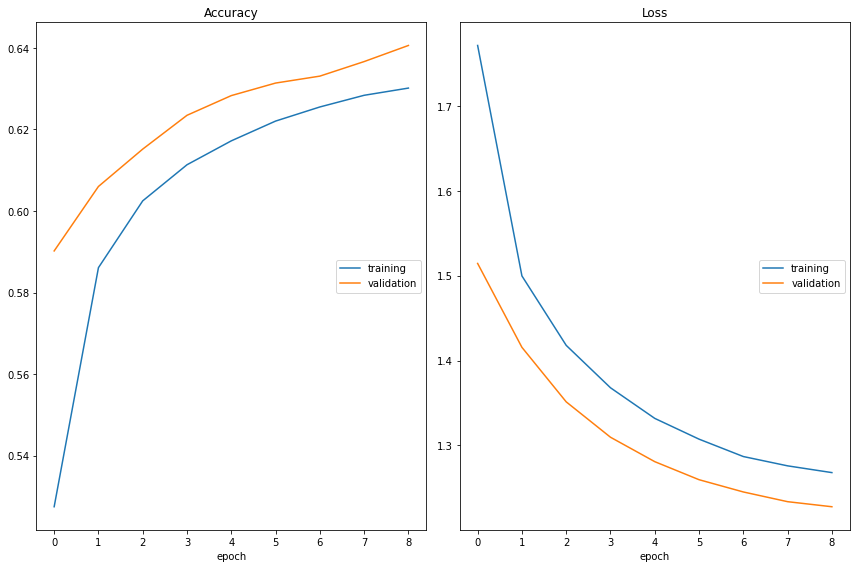

Accuracy
	training         	 (min:    0.527, max:    0.630, cur:    0.630)
	validation       	 (min:    0.590, max:    0.641, cur:    0.641)
Loss
	training         	 (min:    1.268, max:    1.771, cur:    1.268)
	validation       	 (min:    1.228, max:    1.514, cur:    1.228)
174677/174677 [==============================] - 7s 39us/sample - loss: 1.2678 - acc: 0.6302 - val_loss: 1.2276 - val_acc: 0.6406
Epoch 10/1000
167400/174677 [===========================>..] - ETA: 0s - loss: 1.2641 - acc: 0.6311

In [ ]:
#hide
main(lowercase=LOWERCASE, clean=CLEAN, remove_continuations=REMOVE_CONTINUATIONS)